# Supervised Lesion Detector

This notebook is dedicated to training and evaluating a supervised lesion detector on DeepLesion dataset with the following supervised model architectures for image detection with ResNet-50 backbone:
- YOLOv5 (stable, but YOLOv8 is newer),
- Faster R-CNN (torchvision.models.detection or Detectron2),
- DETR (Facebook DETR),
- Improved DETR (DINO-DETR or Deformable DETR, DINO has better performance but Deformable is faster),
- Feature Pyramid Network (RetinaNet, FPN + anchor-based).

## Assumptions:
- Use 2D slice inputs (optionally use the neighbouring ones too),
- Resize all images to 512x512,
- Use COCO-style Dataset class.
- Use DeepLesion for training a general lesion localizer and some other like LiTS (Liver Tumor Segmentation) or CHAOS (CT liver dataset) for more specialized localizer.

## 📚 Thesis Value Summary
### Contribution and Value:
- Comparison of CNN vs Transformer detectors on DeepLesion	-> ✅ Fills a gap in literature
- Evaluation of improved DETRs (DINO/Deformable) -> ✅ Modern insight
- General vs specialized lesion detection -> ✅ Strong clinical relevance
- Analysis of training time, robustness, failure modes -> ✅ Engineering depth


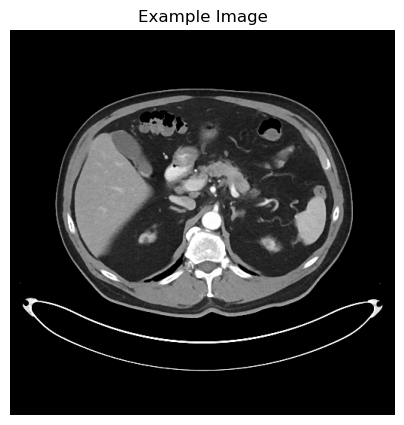

In [14]:
# Test code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from typing import Any
from PIL import Image

def load_metadata(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def normalize(img: NDArray[np.uint16], per_image_norm: bool):
    img = img.astype(np.float32)
    if not per_image_norm:
        return img / 65535.0
    max = np.max(img)
    min = np.min(img)
    img = (img - min) / (max - min)
    return img


def convert_to_hu(img: NDArray[np.uint16], norm: bool, hu_min=-1024, hu_max=3071):
    """
    Converts the pixel data of a uint16
    CT image to Hounsfield Units (HU).
    """

    hu_img = img.astype(np.int32) - 32768
    hu_img = np.clip(hu_img, hu_min, hu_max).astype(np.float32)
    if norm:
        hu_img = (hu_img - hu_min) / (hu_max - hu_min)
        hu_img = np.clip(hu_img, 0.0, 1.0)
    return hu_img

def load_image(
    path: str,
    image_metadata: pd.DataFrame = None,
    hu_scale: bool = True,
    norm: bool = True,
    per_image_norm: bool = True,
):
    img = Image.open(path)
    img_array = np.array(img)
    if hu_scale:
        hu_min = -160
        hu_max = 240
        return convert_to_hu(img_array, norm, hu_min, hu_max)
    elif norm:
        return normalize(img_array, per_image_norm)
    return img_array


def save_image(img_array: NDArray[Any], path: str):
    if img_array.dtype != np.uint16:
        img_array = img_array.astype(np.uint16)
    img = Image.fromarray(img_array)
    img.save(path)


def show_image(img: NDArray[np.float32], title="Example Image", cmap="gray"):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()


metadata_path = "../data/deeplesion_metadata.csv"
image_path = "../data/002783_01_01_064.png"


metadata = load_metadata(metadata_path)
image_data = load_image(image_path, metadata)
show_image(image_data)
